The objective of this short pipeline is to design a recurrent neural network (RNN) with the Long Short Term Memory (LSTM) Model to predict future market closing prices for the Dow Jones Industrial Average (DJIA) through a closed technical analysis approach. It attempts to draw market insights by leveraging underlying relationships between price, information and volume for the index.

<h2> Load Requirements </h2>

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import pickle
import gc
import requests
import urllib.request
import psutil
import sklearn.ensemble
import sklearn.preprocessing
import sklearn.metrics
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LSTM, RNN

Using TensorFlow backend.


In [2]:
djiadata = pd.read_csv('https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=DJIA&apikey='+
            '1D9IC2FZ6E6ABYLY&datatype=csv&outputsize=full')
with open('djia_historic_data.csv', 'wb') as f:
    f.write(djiadata.to_csv(index=False).encode())
djiadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4942 entries, 0 to 4941
Data columns (total 6 columns):
timestamp    4942 non-null object
open         4942 non-null float64
high         4942 non-null float64
low          4942 non-null float64
close        4942 non-null float64
volume       4942 non-null int64
dtypes: float64(4), int64(1), object(1)
memory usage: 231.7+ KB


<h2> Prepare Data </h2>

<b> STEP 1: Clean Dataset </b>

A fine balance must be established between training a network on excessively historic data such that it loses predictive power on current trends, vis-a-vis limited short-term market information. Therefore, it was decided to train the network on data from 2008-2017, test it on 2018-19, and run future predictions. In addition, we are attempting a 'many-to-one' network, effectively trying to predict only day-end closing prices for the index. 

In [3]:
djiadata = djiadata.iloc[::-1].reset_index(drop=True)
djiadata.drop(['open', 'high', 'low', 'volume'], axis=1, inplace=True)
djiadata.timestamp = djiadata.timestamp.apply(lambda s: int(''.join(s.split('-'))))

In [4]:
djiadata.drop(djiadata[djiadata.timestamp < 20080000].index.values, axis=0, inplace=True)
djiadata.reset_index(drop=True, inplace=True)

<b> STEP 2: Add Indicator Features </b>

In order to effectively uncover and dissect market trends, additional indicators and oscillators are added to DJIA data obtained above. The choice of indicators was difficult, mostly to only include tools that are known from constricted present data, and thus moving averages (simple and exponential), bollinger bands, simplified aaron oscillator and change momentum oscillators are used. We engineer said features on  input dataset, and proceed to model development.

In [5]:
#19-Day SMA
djiadata['sma19'] = np.cumsum(djiadata['close'])
djiadata.sma19 = (djiadata.sma19 - djiadata.sma19.shift(19))/19
djiadata.loc[djiadata.index.values==18, 'sma19'] = np.mean(djiadata.close[:19])

In [6]:
#19-Day (Double-Weighted) EMA
djiadata['ema19'] = np.nan
djiadata.loc[:19, 'ema19'] = djiadata.loc[:19, 'sma19']
for i in range(19, len(djiadata)):
    djiadata.loc[i,'ema19']=(djiadata.loc[i,'close']-djiadata.loc[i-1,'ema19'])*0.1 + djiadata.loc[i-1,'ema19']

In [7]:
#19-Day Double-STD Bollinger Bands
lstcls = djiadata['close'].astype('str')
for i in range(1, 19):
    lstcls += ' ' + djiadata['close'].astype('str').shift(i)
stddevval = lstcls.apply(lambda s: s if str(s)=='nan' else np.std(np.vectorize(lambda g: float(g))(s.split())))
djiadata['upperbol'] = djiadata['sma19'] + 2 * stddevval
djiadata['lowerbol'] = djiadata['sma19'] - 2 * stddevval

In [8]:
#Simplified Aaron Oscillator
#lstcls is currently at 19-day
for i in range(19,25):
    lstcls += ' ' + djiadata['close'].astype('str').shift(i)
aarminmax = lstcls.apply(lambda s: s if str(s)=='nan' else np.vectorize(lambda g: float(g))(s.split()))
aarminmax = aarminmax.apply(lambda s: s if str(s)=='nan' else 100*(25-np.argmax(s))/25 - 100*(25-np.argmin(s))/25)
djiadata['aaronval'] = aarminmax

In [9]:
#25-Period Chande Momentum Oscillator
djiadata['highc'] = 0
djiadata['lowc'] = 0
djiadata.loc[djiadata.close < djiadata.close.shift(1), 'lowc'] = djiadata['close']
djiadata.loc[djiadata.close > djiadata.close.shift(1), 'highc'] = djiadata['close']

In [10]:
djiadata['sumhighc'] = np.cumsum(djiadata['highc'])
djiadata['sumhighc'] = djiadata['sumhighc'] - djiadata['sumhighc'].shift(25)
djiadata['sumlowc'] = np.cumsum(djiadata['lowc'])
djiadata['sumlowc'] = djiadata['sumlowc'] - djiadata['sumlowc'].shift(25)
djiadata.loc[djiadata.index==24, ['sumhighc','sumlowc']] = [np.sum(djiadata.highc[:25]), np.sum(djiadata.lowc[:25])]

In [11]:
djiadata['chande'] = (djiadata['sumhighc']-djiadata['sumlowc'])/(djiadata['sumhighc']+djiadata['sumlowc']) * 100
djiadata.drop(['highc', 'lowc', 'sumhighc', 'sumlowc'], axis=1, inplace=True)
djiadata = djiadata.dropna(axis=0)
djiadata.reset_index(drop=True, inplace=True)

<b> STEP 3: Data Scaling </b>

We must scale all data down to a specified feature range so that it is significantly easier for the model to learn underlying data trends. In interest of the same, it was decided to min-max scale each feature to [0,1]. This choice was primarily driven by the lack of outliers in the data that nullify the robustness advantage of standardization, along with the simplicity of scaling back and forth based on minima and maxima.

In [12]:
sc = sklearn.preprocessing.MinMaxScaler(feature_range=(0,1), copy=True)
cols = djiadata.columns.values[1:]
djiadata[cols] = pd.DataFrame(sc.fit_transform(djiadata[cols]), columns=cols)

In [13]:
with open('scaler.pkl', 'wb') as f:
    pickle.dump(sc, f)

<b> STEP 3: Design Input for Recurrent Neural Network

For our LSTM-based Recurrent Neural Network, we decide to have 50 time-stamps at a time, allowing the model to predict the 51st closing price. The rationale behind choosing a 50-time frame was to balance between short-term trends and long-term market indicators, whilst ensuring that all 19- and 25-day oscillators were adequately represented in each model training sequence. Thus, each time-stamp is a 7-element numpy array containing the current closing price, 19-day simple and exponential moving averages, upper and lower bollinger bands, as well as a simplified aaron and chande momentum oscillator, in said order. We thus convert our dataset into independent and response variable sets.

In [31]:
time_stamp_num = 50

In [32]:
Y = djiadata.close[time_stamp_num:].values

In [33]:
rawdata = djiadata.values[:, 1:]
X = np.zeros((len(djiadata)-time_stamp_num, time_stamp_num, 7), dtype='float')
for i in range(len(djiadata)-time_stamp_num):
    X[i, :, :] = rawdata[i:i+time_stamp_num]

In [34]:
X.shape, Y.shape

((2858, 50, 7), (2858,))

<h2> Design Recurrent Neural Network </h2>

<b> STEP 1: Separate Train and Test Sets </b>

In [35]:
#2008-2018 is the training set, and 2019 YTD is the test set
#Define the number of entries in the test set
sum(djiadata.timestamp > 20180000)

414

In [36]:
testsize = sum(djiadata.timestamp > 20180000)
trainx = X[:-testsize, :, :]
testx = X[-testsize:, :, :]
trainy = Y[:-testsize]
testy = Y[-testsize:]
trainx.shape, testx.shape, trainy.shape, testy.shape

((2444, 50, 7), (414, 50, 7), (2444,), (414,))

<b> STEP 2: Build and Train Network </b>

When designing the model's architecture, LSTM cells were chosen over simple RNN cells available through Tensorflow in order to accomodate the model's ability to learn long-term dependencies in the time-series data. Multiple layers of LSTM cells were decided to be stacked for greater memory retention. The exact architecture planned was as follows:

1) First Layer of LSTM cells, returns sequence to next

2) Second layer of LSTM cells, returns sequence to next

3) Third layer of LSTM cells, returns last-value for time-stamps

4) Dense (fully-connected) layer returning the actual 51st period closing price

In [70]:
def mdlbdr():
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(50, 7)))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(LSTM(units=50))
    model.add(Dense(units=25, activation='relu'))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [ ]:
chk = ModelCheckpoint('./djiarnn2.h5', monitor='loss', save_best_only=True, period=10)
callbacklist = [chk]
djmdl = KerasRegressor(build_fn=mdlbdr, epochs=100, batch_size=30, verbose=True, callbacks=callbacklist,
                      validation_data=(testx, testy))
djmdl.fit(trainx, trainy)
djmdl.model.save('./djiarnn2.h5')

<b> STEP 3: Run Test Data </b>

In [62]:
Ypred = djmdl.predict(testx)

414/414 [==============================] - 0s 922us/step


In [63]:
tmp = np.concatenate([Ypred.reshape(-1,1), np.zeros((len(Ypred), 6))], axis=1)
Ypredorig = sc.inverse_transform(tmp)[:, 0]
tmpt = np.concatenate([testy.reshape(-1,1), np.zeros((len(testy), 6))], axis=1)
testyorig = sc.inverse_transform(tmpt)[:, 0]

In [64]:
sklearn.metrics.mean_absolute_error(testyorig, Ypredorig)

288.5336221965307

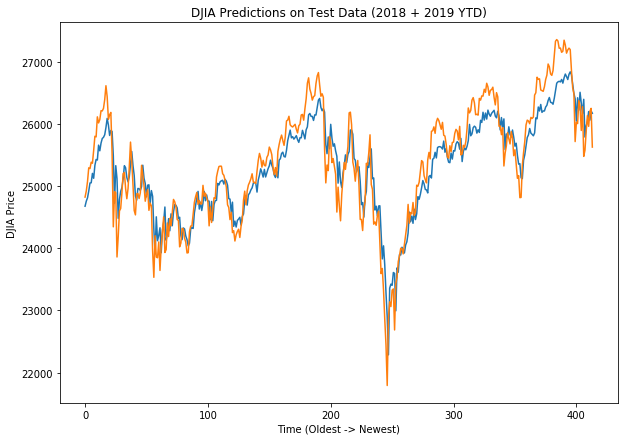

In [65]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
plt.plot(Ypredorig)
plt.plot(testyorig)
plt.title('DJIA Predictions on Test Data (2018 + 2019 YTD)')
plt.xlabel('Time (Oldest -> Newest)')
plt.ylabel('DJIA Price')
plt.show()

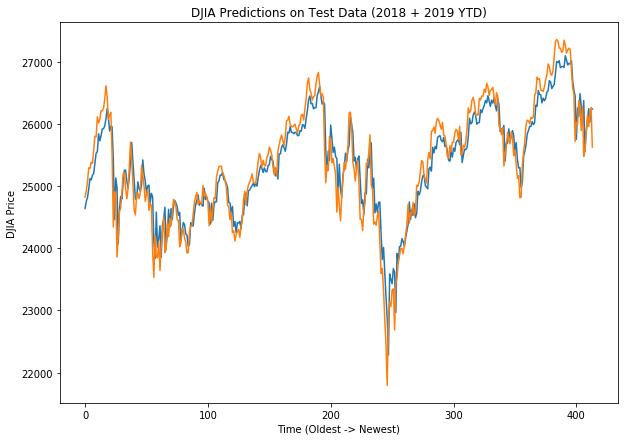

In [48]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
plt.plot(Ypredorig)
plt.plot(testyorig)
plt.title('DJIA Predictions on Test Data (2018 + 2019 YTD)')
plt.xlabel('Time (Oldest -> Newest)')
plt.ylabel('DJIA Price')
plt.show()

<b> STEP 4: Build September Future-Prediction Algorithm </b>

In [30]:
djiadata

,timestamp,close,sma19,ema19,upperbol,lowerbol,aaronval,chande
0,20080206,0.271623,0.267903,0.269703,0.260411,0.275077,0.250000,0.410550
1,20080207,0.273877,0.266316,0.268416,0.256922,0.275427,0.250000,0.443402
2,20080208,0.270760,0.265205,0.266932,0.255710,0.274450,0.354167,0.380039
3,20080211,0.273541,0.263795,0.265887,0.252283,0.275087,0.354167,0.442793
4,20080212,0.279950,0.263461,0.265615,0.251624,0.275086,0.354167,0.441614
5,20080213,0.288543,0.263686,0.266267,0.252234,0.274922,0.354167,0.504876
6,20080214,0.280122,0.264257,0.265975,0.252344,0.275933,0.354167,0.441655
7,20080215,0.278740,0.264909,0.265567,0.252063,0.277494,0.395833,0.378020
8,20080219,0.278212,0.265867,0.265146,0.250566,0.280865,0.395833,0.378622
9,20080220,0.282538,0.266279,0.265218,0.250765,0.281476,0.666667,0.377634
